In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
from datetime import datetime

In [3]:
from sklearn.metrics import mean_squared_error,r2_score
from scipy import interpolate

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [5]:
df = pd.read_csv('./municipality_bus_utilization.csv', parse_dates=["timestamp"])
df

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


In [6]:
df.describe()

,municipality_id,usage,total_capacity
count,13070.000000,13070.000000,13070.000000
mean,4.500000,876.002984,1972.800000
std,2.872391,679.287109,1144.074782
min,0.000000,11.000000,397.000000
25%,2.000000,403.000000,697.000000
50%,4.500000,692.000000,1974.500000
75%,7.000000,1190.000000,2947.000000
max,9.000000,3508.000000,3893.000000


### Base model
We just consider the day of the week, hour of the day and id
<br>
No temporal component added

In [7]:
#we get day of week and time for each row
df_base = df.copy()
df_base["day_of_week"] = df.timestamp.dt.dayofweek
df_base["hour_of_day"] = df.timestamp.dt.hour

In [8]:
#separate the test set
t0 = datetime.strptime("2017-08-05 00:00", "%Y-%m-%d %H:%M")
dfb_train = df_base[df_base['timestamp']<t0] 
dfb_test = df_base[df_base['timestamp']>=t0]

In [9]:
#Our base model predicts the usage for a given id as the max usage of the same day of week and hour of day
group_id_day_hour = dfb_train.groupby(by=["municipality_id","day_of_week", "hour_of_day"])["usage"].agg(np.max)
group_id_day_hour

municipality_id  day_of_week  hour_of_day
0                0            7              255
                              8              548
                              9              665
                              10             751
                              11             766
                                            ... 
9                6            12             861
                              13             863
                              14             864
                              15             832
                              16             742
Name: usage, Length: 700, dtype: int64

In [10]:
#we construct a simple lookup table for the base model
base_lookup = group_id_day_hour.to_dict()
def base_predict(features):
    y_pred = []
    for x in features:
        y_pred.append(base_lookup[tuple(x)])
    return np.array(y_pred)

In [11]:
ybase = base_predict(dfb_test[["municipality_id", "day_of_week", "hour_of_day"]].values)

In [12]:
np.sqrt(((ybase-dfb_test['usage'])**2).sum()/len(ybase))

312.4021422901301

In [13]:
print("RMSE \t R^2")
print("{:0.2f} \t {:0.2f}".format( \
    mean_squared_error(dfb_test['usage'], ybase, squared=False), \
    r2_score(dfb_test['usage'], ybase) \
     ))

RMSE 	 R^2
312.40 	 0.81


### Time series model
As suggested by the assignement

In [14]:
## Time series model
dfmodel = df.copy()

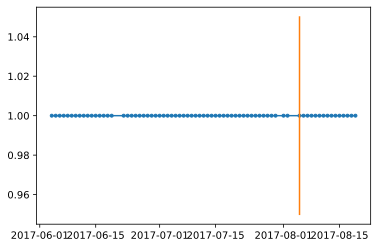

In [15]:
dates = dfmodel['timestamp'].dt.date.unique()
plt.plot(dates,np.ones_like(dates),'.-')
t0 = datetime.strptime("2017-08-05 00:00", "%Y-%m-%d %H:%M")
plt.plot([t0.date(),t0.date()],[0.95,1.05])

There are missing data for the part we are expected to use as training set but not for the test set.
<br>
We create a new dataset which also represents missing data

In [16]:
dfmodel["day_of_year"] = dfmodel['timestamp'].dt.dayofyear
dfmodel["hour"] = dfmodel['timestamp'].dt.hour

In [17]:
#We aggregate by max value as suggested by the assignment
aggregate = dfmodel.groupby(by=["municipality_id","day_of_year", "hour"])["usage"].agg(np.max).to_frame()
aggregate

usage
municipality_id day_of_year hour       
0               155         7       204
                            8       332
                            9       485
                            10      583
                            11      614
...                                 ...
9               231         12      849
                            13      941
                            14      983
                            15      976
                            16      879

[6740 rows x 1 columns]

In [18]:
index = aggregate.index
#
municipal = index.get_level_values(0).unique().to_numpy()
#
daymin = index.get_level_values(1).min()
daymax = index.get_level_values(1).max()
days = np.arange(daymin, daymax+1)
#
hours = index.get_level_values(2).unique().to_numpy()
#
data_with_na = []
for m in municipal:
    for d in days:
        for h in hours:
            try:
                data_with_na.append([m,d,h,aggregate.loc[m,d,h].values[0]])
            except:
                data_with_na.append([m,d,h,np.nan])
data_with_na = np.array(data_with_na)

In [19]:
data_with_na

array([[  0., 155.,   7., 204.],
       [  0., 155.,   8., 332.],
       [  0., 155.,   9., 485.],
       ...,
       [  9., 231.,  14., 983.],
       [  9., 231.,  15., 976.],
       [  9., 231.,  16., 879.]])

#### Interpolation

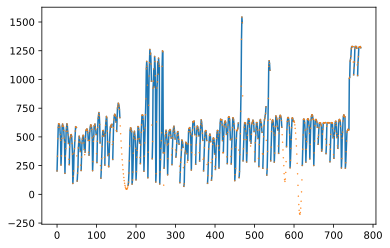

In [20]:
y = data_with_na[data_with_na[:,0]==0][:,3]
x = np.arange(len(y))

idx_finite = np.isfinite(y)
f_finite = interpolate.interp1d(x[idx_finite], y[idx_finite], kind='quadratic')
ynew_finite = f_finite(x)
plt.plot(x,y)
plt.plot(x,ynew_finite, '.',ms=1)

It seems quadratic or cubic interpolation may offshoot the curve
<br>
So we stick to the linear interpolation

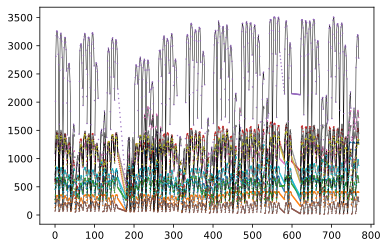

In [21]:
data_interpolated =  np.append(data_with_na, np.zeros(shape=(data_with_na.shape[0],1)), 1)
for m in municipal:
    y = data_with_na[data_with_na[:,0]==m][:,3]
    x = np.arange(len(y))
    
    plt.plot(x,y,"k-", lw=0.5)

    idx_finite = np.isfinite(y)
    f_finite = interpolate.interp1d(x[idx_finite], y[idx_finite], kind='linear')
    ynew_finite = f_finite(x)
    
    data_interpolated[data_interpolated[:,0]==m,4] = ynew_finite
    
    plt.plot(x,ynew_finite, '.',ms=1)    
    

#### Time series model
We use Arima type model for temporal forecasts

In [22]:
timeseries_train = {}
timeseries_test = {}
test_set_lim =620
for i in municipal:
    timeseries_train[i] = data_interpolated[data_interpolated[:,0]==i][:test_set_lim,4]
    timeseries_test[i] = data_interpolated[data_interpolated[:,0]==i][test_set_lim:,4]

In [23]:
#ARIMA type models
#There are 10 data points per day so we pick period=10 to capture daily cycles

In [24]:
model_fits = {}
model_forecasts={}
for i in range(10):
    data = timeseries_train[i]
    model = ARIMA(data, order=(0, 0, 0),seasonal_order=(1, 1, 1, 10))
    model_fits[i] = model.fit()
    
    ypred = model_fits[i].forecast(len(timeseries_test[i]))
    model_forecasts[i] = ypred

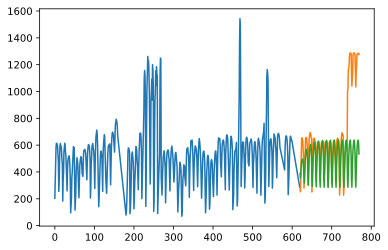

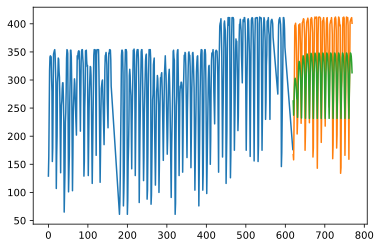

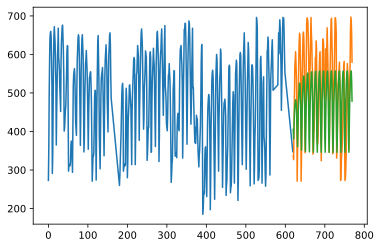

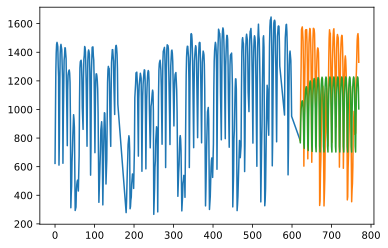

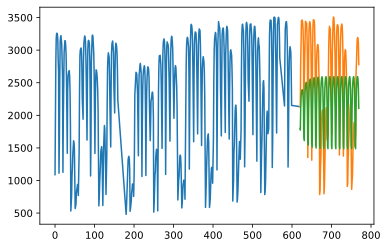

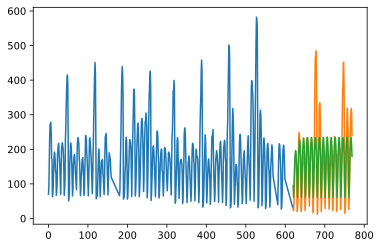

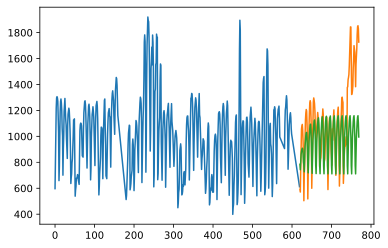

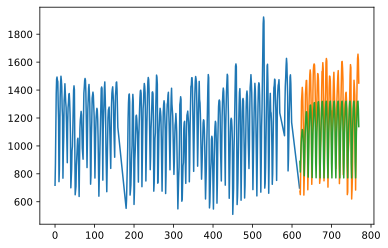

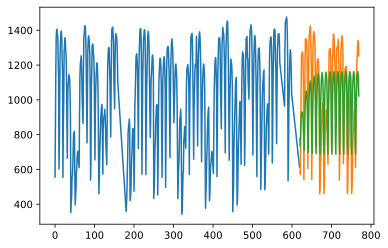

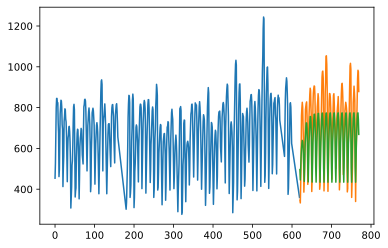

In [25]:
for i in range(10):
    plt.figure()

    y1 = timeseries_train[i]
    y2 = timeseries_test[i]
    y2p = model_forecasts[i]

    plt.plot(np.arange(len(y1)),y1)
    plt.plot(np.arange(len(y2))+len(y1),y2)

    #y1p = model_fit.predict()
    #plt.plot(np.arange(len(y1p)),y1p, 'r.')

    plt.plot(np.arange(len(y2p))+len(y1),y2p)

In [26]:
ytrue = []
ypred = []

for i in range(10):
    ytrue.extend(list(timeseries_test[i]))    
    ypred.extend(list(model_forecasts[i]))
    
print("RMSE \t R^2")
print("{:0.2f} \t {:0.2f}".format( \
    mean_squared_error(ytrue, ypred, squared=False), \
    r2_score(ytrue, ypred) \
     ))

RMSE 	 R^2
299.19 	 0.82


### Comments
Our basic temporal model improved RMSE with respect to the base model.
<br>
It can be further improved by parameter tuning ARIMA models.
<br>
Using a NN approach with embedding vectors may be an alternative to this timeseries approach. There is an example of that in fast.ai based on Kaggle-Rossmann dataset. 